In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from typing import Union
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


In [5]:
sales= pd.read_pickle('../data/processed/item_sales.pkl') 
price =pd.read_pickle('../data/processed/item_prices.pkl') 
cal = pd.read_pickle('../data/processed/daily_calendar_with_events.pkl') 


In [77]:
price =pd.read_pickle('../data/processed/item_prices.pkl') 

In [24]:
data = pd.read_pickle('../data/processed/fe2_data.pkl')

In [25]:
data.head()

,id,item,category,department,store_code,region,d,sales,weekday_int,event,...,lag_2,lag_3,lag_5,lag_7,lag_14,lag_21,lag_28,rolling_mean_10,rolling_mean_20,rolling_mean_30
30490000,3,ACCESORIES_1_001,ACCESORIES,0,NYC_1,1,1001,2,7,-1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.3,0.40,0.433333
30490001,13,ACCESORIES_1_002,ACCESORIES,0,NYC_1,1,1001,0,7,-1,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.10,0.200000
30490002,23,ACCESORIES_1_003,ACCESORIES,0,NYC_1,1,1001,0,7,-1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000
30490003,33,ACCESORIES_1_004,ACCESORIES,0,NYC_1,1,1001,0,7,-1,...,2.0,1.0,2.0,1.0,0.0,3.0,0.0,1.7,1.70,1.800000
30490004,43,ACCESORIES_1_005,ACCESORIES,0,NYC_1,1,1001,1,7,-1,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.05,1.033333


In [13]:
sales.head()

,id,item,category,department,store,store_code,region,d_1,d_2,d_3,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,ACCESORIES_1_005_NYC_1,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [30]:
data['item'] = data['item'].astype('category')
data['category'] = data['category'].astype('category')
data['store_code'] = data['store_code'].astype('category')

In [33]:
cols = data.dtypes.index.tolist()
d_types = data.dtypes.values.tolist()

for i,type in enumerate(d_types):
    if type.name == 'category':
        data[cols[i]] = data[cols[i]].cat.codes

In [35]:
data.head()

,id,item,category,department,store_code,region,d,sales,weekday_int,event,...,lag_2,lag_3,lag_5,lag_7,lag_14,lag_21,lag_28,rolling_mean_10,rolling_mean_20,rolling_mean_30
30490000,3,0,0,0,3,1,1001,2,7,-1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.3,0.40,0.433333
30490001,13,1,0,0,3,1,1001,0,7,-1,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.10,0.200000
30490002,23,2,0,0,3,1,1001,0,7,-1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000
30490003,33,3,0,0,3,1,1001,0,7,-1,...,2.0,1.0,2.0,1.0,0.0,3.0,0.0,1.7,1.70,1.800000
30490004,43,4,0,0,3,1,1001,1,7,-1,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.05,1.033333


In [15]:
print(1913*0.6)  # <=1147 treino 60%
print((1913-1147)/2) # 383 validação 20%
#383 teste 20%


1147.8
383.0


In [40]:
#Data Distribution

X_train = data[data['d']<=1147]
X_val = data[(data['d']>1147) & (data['d']<=1530)]
X_test = data[(data['d']>1530)]

y_train = X_train['sales']
y_val = X_val['sales']
y_test = X_test['sales']

X_train.drop(['id', 'd','sales', 'yearweek','week','day'],axis = 1,inplace = True)
X_val.drop(['id', 'd','sales', 'yearweek','week','day'],axis = 1,inplace = True)
X_test.drop(['id', 'd','sales', 'yearweek','week','day'],axis = 1,inplace = True)

print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape)

(4482030, 21) (4482030,)
(11677670, 21) (11677670,)
(11677670, 21)


In [18]:
del data

In [37]:
X_train.head()

,item,category,department,store_code,region,weekday_int,event,year,month,sell_price,...,lag_2,lag_3,lag_5,lag_7,lag_14,lag_21,lag_28,rolling_mean_10,rolling_mean_20,rolling_mean_30
30490000,0,0,0,3,1,7,-1,2013,10,10.984375,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.3,0.40,0.433333
30490001,1,0,0,3,1,7,-1,2013,10,5.281250,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.10,0.200000
30490002,2,0,0,3,1,7,-1,2013,10,3.949219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000
30490003,3,0,0,3,1,7,-1,2013,10,6.171875,...,2.0,1.0,2.0,1.0,0.0,3.0,0.0,1.7,1.70,1.800000
30490004,4,0,0,3,1,7,-1,2013,10,4.097656,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.05,1.033333


In [83]:
class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -383:].columns.tolist()

        train_df['all_id'] = 0  # for lv1 aggregation

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')].columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')].columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'region',
            'store_code',
            'category',
            'department',
            ['region', 'category'],
            ['region', 'department'],
            ['store_code', 'category'],
            ['store_code', 'department'],
            'item',
            ['item', 'region'],
            ['item', 'store_code']
        )

        for i, group_id in enumerate(tqdm(self.group_ids)):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)[valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['yearweek'].to_dict()
        weight_df = self.train_df[['item', 'store_code'] + self.weight_columns].set_index(['item', 'store_code'])
        weight_df = weight_df.stack().reset_index().rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['yearweek'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left', on=['item', 'store_code', 'yearweek'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item', 'store_code', 'd']).unstack(level=2)['value']
        weight_df = weight_df.loc[zip(self.train_df.item, self.train_df.store_code), :].reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns], weight_df], axis=1, sort=False)
        return weight_df

    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')
        return (score / scale).map(np.sqrt)

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds], axis=1, sort=False)

        all_scores = []
        for i, group_id in enumerate(self.group_ids):
            lv_scores = self.rmsse(valid_preds.groupby(group_id)[self.valid_target_columns].sum(), i + 1)
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, sort=False).prod(axis=1)
            print(lv_scores.sum())
            all_scores.append(lv_scores.sum())

        return np.mean(all_scores)

    

In [41]:
#Hyeperparameter tuning
#Manually tuning learning_rate and max_depth

lr = [0.01, 0.05, 0.1]
md = [3, 5, 7]

for i in lr:
    for j in md:
        xgb_ht = XGBRegressor(objective = 'reg:tweedie', learning_rate = i, max_depth = j, subsample = 0.7, 
                              colsample_bytree = 0.7, n_estimators = 100) 
        
        xgb_ht.fit(X_train,y_train)
        y_pred = xgb_ht.predict(X_test)
        rmse = mean_squared_error(y_test,y_pred) ** 0.5
        print("*" * 50)
        print(f"For learning_rate = {i} and max_depth = {j}, the rmse = {rmse}")
        print("*" * 50)

**************************************************
For learning_rate = 0.01 and max_depth = 3, the rmse = 3.352558263717589
**************************************************
**************************************************
For learning_rate = 0.01 and max_depth = 5, the rmse = 3.340260761840651
**************************************************
**************************************************
For learning_rate = 0.01 and max_depth = 7, the rmse = 3.3370365235339294
**************************************************
**************************************************
For learning_rate = 0.05 and max_depth = 3, the rmse = 2.074555278138132
**************************************************
**************************************************
For learning_rate = 0.05 and max_depth = 5, the rmse = 1.9340652045192352
**************************************************
**************************************************
For learning_rate = 0.05 and max_depth = 7, the rmse = 1.872159904998674

In [42]:
xgb = XGBRegressor(objective = 'reg:tweedie', learning_rate = 0.1, max_depth = 7, subsample = 0.7, 
                   colsample_bytree = 0.7, n_estimators = 100)

xgb.fit(X_train,y_train, eval_set=[(X_val,y_val)], eval_metric='rmse', verbose=10)

[0]	validation_0-rmse:3.65901
[10]	validation_0-rmse:3.28465
[20]	validation_0-rmse:2.64476
[30]	validation_0-rmse:2.11530
[40]	validation_0-rmse:1.91492
[50]	validation_0-rmse:1.87459
[60]	validation_0-rmse:1.86058
[70]	validation_0-rmse:1.85367
[80]	validation_0-rmse:1.84800
[90]	validation_0-rmse:1.84008
[99]	validation_0-rmse:1.83597


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=7, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:tweedie', predictor='auto', ...)

In [43]:
import pickle
pickle.dump(xgb,open('xgb.pkl','wb'))

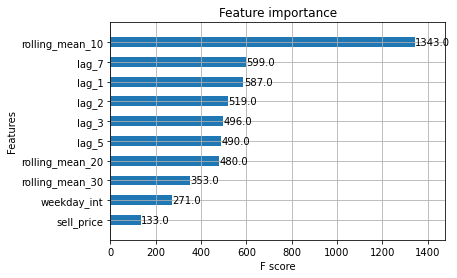

In [44]:
from xgboost import plot_importance

plot_importance(xgb,max_num_features = 10, height = 0.5)
plt.show()

In [47]:
len(pred_val_array)

11677670

In [51]:
pred_val_array  = xgb.predict(X_val)
pred_test_array  = xgb.predict(X_test)

pred_val_array = np.reshape(pred_val_array, (-1, 383),order = 'F')
pred_test_array = np.reshape(pred_test_array, (-1, 383),order = 'F')

In [79]:
price['yearweek']=price['yearweek'].astype('object')

In [73]:
price.head()

,item,category,store_code,yearweek,sell_price
0,ACCESORIES_1_001,ACCESORIES,NYC_1,201328,12.742188
1,ACCESORIES_1_001,ACCESORIES,NYC_1,201329,12.742188
2,ACCESORIES_1_001,ACCESORIES,NYC_1,201330,10.984375
3,ACCESORIES_1_001,ACCESORIES,NYC_1,201331,10.984375
4,ACCESORIES_1_001,ACCESORIES,NYC_1,201332,10.984375


In [64]:
cal['date'] = pd.to_datetime(cal['date'])
cal['year'] = cal['date'].dt.year
cal['week'] = cal['date'].dt.isocalendar().week.apply(str)
cal['week'] = cal['week'].apply(lambda x: x.zfill(2))
cal['yearweek'] = cal['year'].apply(str) + cal['week']

In [69]:
cal = cal.drop(['year','week'], axis=1)

In [70]:
cal.head()

,date,weekday,weekday_int,d,event,yearweek
0,2011-01-29,Saturday,1,d_1,NaN,201104
1,2011-01-30,Sunday,2,d_2,NaN,201104
2,2011-01-31,Monday,3,d_3,NaN,201105
3,2011-02-01,Tuesday,4,d_4,NaN,201105
4,2011-02-02,Wednesday,5,d_5,NaN,201105


In [84]:
d_cols = [d for d in sales.columns if 'd_' in d][-383:]
preds_val = pd.DataFrame(pred_val_array,columns = d_cols)
train_df = sales.iloc[:,:-383]
val_df = sales.iloc[:,-383:]
evaluator = WRMSSEEvaluator(train_df, val_df, cal, price)
score = evaluator.score(preds_val)
print("WRMSSE score of validation data [for days 1147-1530]:",score)

100%|██████████| 12/12 [00:34<00:00,  2.88s/it]


1.7586682125910842
4.962216898480035
16.770281937740606
5.6262058518771125
14.168991580942068
15.44103677634734
36.925925733377646
48.8657175833294
117.77753630360058
3762.817697921626
inf
inf
WRMSSE score of validation data [for days 1147-1530]: inf


In [76]:
score = evaluator.score(preds_val)

,d_1531,d_1532,d_1533,d_1534,d_1535,d_1536,d_1537,d_1538,d_1539,d_1540,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
30488,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3
30489,1,2,2,4,3,0,3,0,4,0,...,0,0,0,0,0,0,0,0,0,0
